In [30]:
import re
import numpy as np
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Embedding, Lambda

from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
import gensim
from keras.preprocessing import text
from keras.preprocessing import sequence

In [31]:
import nltk
from nltk.corpus import stopwords
#nltk.download('stopwords')
stop_words = set(stopwords.words('english')) 

In [32]:
def get_file_data(stop_word_removal='no'):
    file_contents = []
    with open('data/DL.txt',encoding="utf8") as f:
        file_contents = f.read()
    
    text1 = []
    #print(file_contents)
    for val in file_contents.split('.'):
        sent = re.findall("[A-Za-z]+", val)
        line = ''
        for words in sent:
            
            if stop_word_removal == 'yes': 
                if len(words) > 1 and words not in stop_words:
                    line = line + ' ' + words
            else:
                if len(words) > 1 :
                    line = line + ' ' + words
        text1.append(line)
        
    return text1

In [33]:
dataset=get_file_data("yes")

In [34]:
tokenizer = text.Tokenizer()
tokenizer.fit_on_texts(dataset)
word2id = tokenizer.word_index

In [35]:
# build vocabulary of unique words
word2id['PAD'] = 0
id2word = {v:k for k, v in word2id.items()}
wids = [[word2id[w] for w in text.text_to_word_sequence(doc)] for doc in dataset]

vocab_size = len(word2id)
embed_size = 100
window_size = 2 # context window size

print('Vocabulary Size:', vocab_size)
print('Vocabulary Sample:', list(word2id.items())[:10])

Vocabulary Size: 571
Vocabulary Sample: [('learning', 1), ('deep', 2), ('word', 3), ('data', 4), ('words', 5), ('dog', 6), ('the', 7), ('model', 8), ('layer', 9), ('neural', 10)]


In [36]:
def generate_context_word_pairs(corpus, window_size, vocab_size):
    context_length = window_size*2
    for words in corpus:
        sentence_length = len(words)
        for index, word in enumerate(words):
            context_words = []
            label_word   = []            
            start = index - window_size
            end = index + window_size + 1
            
            context_words.append([words[i] 
                                 for i in range(start, end) 
                                 if 0 <= i < sentence_length 
                                 and i != index])
            label_word.append(word)

            x = sequence.pad_sequences(context_words, maxlen=context_length)
            y = np_utils.to_categorical(label_word, vocab_size)
            yield (x, y)

In [37]:
# Test this out for some samples
i = 0
for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
    if 0 not in x[0]:
        print('Context (X):', [id2word[w] for w in x[0]], '-> Target (Y):', id2word[np.argwhere(y[0])[0][0]])
    
        if i == 10:
            break
        i += 1

Context (X): ['this', 'model', 'google', 'predictive'] -> Target (Y): created
Context (X): ['model', 'created', 'predictive', 'deep'] -> Target (Y): google
Context (X): ['created', 'google', 'deep', 'learning'] -> Target (Y): predictive
Context (X): ['google', 'predictive', 'learning', 'based'] -> Target (Y): deep
Context (X): ['predictive', 'deep', 'based', 'model'] -> Target (Y): learning
Context (X): ['deep', 'learning', 'model', 'compute'] -> Target (Y): based
Context (X): ['learning', 'based', 'compute', 'generate'] -> Target (Y): model
Context (X): ['based', 'model', 'generate', 'high'] -> Target (Y): compute
Context (X): ['model', 'compute', 'high', 'quality'] -> Target (Y): generate
Context (X): ['compute', 'generate', 'quality', 'distributed'] -> Target (Y): high
Context (X): ['generate', 'high', 'distributed', 'continuous'] -> Target (Y): quality


In [38]:
# build CBOW architecture
cbow = Sequential()
cbow.add(Embedding(input_dim=vocab_size, output_dim=embed_size, input_length=window_size*2))
cbow.add(Lambda(lambda x: K.mean(x, axis=1), output_shape=(embed_size,)))
cbow.add(Dense(vocab_size, activation='softmax'))
cbow.compile(loss='categorical_crossentropy', optimizer='rmsprop')

# view model summary
print(cbow.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 4, 100)            57100     
_________________________________________________________________
lambda (Lambda)              (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 571)               57671     
Total params: 114,771
Trainable params: 114,771
Non-trainable params: 0
_________________________________________________________________
None


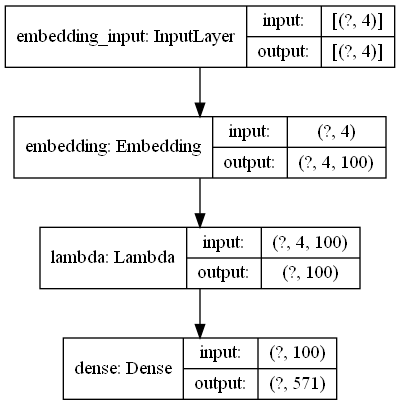

In [43]:
from keras.utils.vis_utils import plot_model
plot_model(cbow,show_shapes=True, to_file='Output/cbow.png')

In [44]:
for epoch in range(1, 200):
    loss = 0.
    i = 0
    for x, y in generate_context_word_pairs(corpus=wids, window_size=window_size, vocab_size=vocab_size):
        i += 1
        loss += cbow.train_on_batch(x, y)
        if i % 100000 == 0:
            print('Processed {} (context, word) pairs'.format(i))

    print('Epoch:', epoch, '\tLoss:', loss)
    print()

Epoch: 1 	Loss: 7807.674807071686

Epoch: 2 	Loss: 7380.792014241219

Epoch: 3 	Loss: 7150.987548828125

Epoch: 4 	Loss: 6962.437099814415

Epoch: 5 	Loss: 6792.8390456438065

Epoch: 6 	Loss: 6657.347818434238

Epoch: 7 	Loss: 6563.679421439767

Epoch: 8 	Loss: 6513.450838908553

Epoch: 9 	Loss: 6506.059547163546

Epoch: 10 	Loss: 6526.664492320269

Epoch: 11 	Loss: 6555.011340744793

Epoch: 12 	Loss: 6573.33907825686

Epoch: 13 	Loss: 6571.588911702856

Epoch: 14 	Loss: 6551.421761622652

Epoch: 15 	Loss: 6519.226769493893

Epoch: 16 	Loss: 6480.11522905156

Epoch: 17 	Loss: 6435.836547961459

Epoch: 18 	Loss: 6387.9466357994825

Epoch: 19 	Loss: 6338.561474606395

Epoch: 20 	Loss: 6288.677870532498

Epoch: 21 	Loss: 6238.246385181323

Epoch: 22 	Loss: 6187.862060255371

Epoch: 23 	Loss: 6137.786217527464

Epoch: 24 	Loss: 6087.890721009113

Epoch: 25 	Loss: 6038.667648517527

Epoch: 26 	Loss: 5990.3617402417585

Epoch: 27 	Loss: 5943.3090226324275

Epoch: 28 	Loss: 5897.495130268857
